In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%matplotlib inline
!pip install utils
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
from scipy.special import logsumexp
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, calinski_harabasz_score


# from numpy import einsum


plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(3.3, 
                         0.66 * 6.7),
                dpi=120)
plt.rc('savefig', dpi=300)
plt.rc('font', size=8)

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


def plot_clusters(Y, mus, covs, labels, K, ax):
    cmap = plt.cm.get_cmap('hsv', K)
    colors = ['red', 'blue', 'green']
    for j in range(np.unique(labels).shape[0]):
        Y_j = Y[(labels == (j))]
        print("----", Y_j.shape)
        ax.scatter(Y_j[:, 0], Y_j[:, 1], color=colors[j])
    for i in range(K):
        plot_cov_ellipse(cov=covs[i],
                         pos=mus[i],
                         nstd=2,
                         ax=ax,
                         color=cmap(i),
                         alpha=0.1)


In [ ]:
url="/content/drive/My Drive/UMLAssignment2/gmm_dataset/"
dataset3 = np.loadtxt(url + "dataset3.txt",delimiter="\t")

url="/content/drive/My Drive/UMLAssignment2/gmm_dataset/" 
dataset2 = np.loadtxt(url + "dataset2.txt", delimiter="\t")#dataset 2
url="/content/drive/My Drive/UMLAssignment2/gmm_dataset/"
dataset1 = np.loadtxt(url + "dataset1.txt", delimiter="\t")#dataset 1
url="/content/drive/My Drive/UMLAssignment2/gmm_dataset/"
dataset3 = np.loadtxt(url + "dataset3.txt", delimiter="\t")


data1 = dataset1[:,0:2]#numerical values from 0 and 1st Column
data2 = dataset2[:,0:2]#numerical values from 0 and 1st column
data3 = dataset3[:,0:2]

labels1 = dataset1[:,2].astype(int)#values of integers in column 2 
labels2 = dataset2[:,2].astype(int)
labels3 = dataset3[:,2].astype(int)


In [ ]:
data1

array([[-1.63879970e-01, -2.19868684e-01],
       [-8.86273730e-01, -3.56186134e-01],
       [-9.78910118e-01, -8.93313889e-01],
       [-6.58866726e-01, -3.71121942e-01],
       [-7.25176598e-02,  3.99157243e-01],
       [-4.28767080e-01, -1.20237470e+00],
       [-3.90458694e-01, -8.62252101e-01],
       [ 3.00334716e-03,  2.14300292e-01],
       [-3.95071205e-01, -5.61381350e-01],
       [-1.00918062e+00, -7.69376512e-01],
       [-1.23404276e-01,  4.61361808e-02],
       [-2.86973455e-01,  4.67501152e-01],
       [-5.39529071e-01, -1.02398646e+00],
       [-6.84715149e-01, -9.44408213e-01],
       [-7.43545059e-01, -6.51788216e-01],
       [-5.10736116e-01, -5.05170363e-01],
       [-8.58000591e-01, -6.37615361e-01],
       [-7.29058495e-01, -7.35546241e-01],
       [-1.16486144e+00, -3.60063591e-01],
       [-7.31943705e-01, -9.68243465e-01],
       [-8.10021456e-01, -5.76010918e-01],
       [-2.41666272e-01,  1.24944018e-02],
       [ 1.50681007e-01, -2.93453257e-02],
       [-3.

Distance Function based on L2 Norm $$\sqrt{(x1-x2)^2+(y1-y2)^2}$$  where each A=[x1,y1] and B=[x2,y2]

In [ ]:
data1.shape


(150, 2)

In [ ]:
import numpy as np

def distfunct(x,y):
  z=np.subtract(x,y)
  dist1=np.linalg.norm(z)
  return dist1


In [ ]:
#function to calculate distance of all points except the point itself (s)
def rangequery(z,distfunct,j,epsilon):#q is the point against which we are measuring distances 
  N=[]
  z=z
  q=j# assign the index as the point for which we need to calculate the distance from other points 
  for s in range(z.shape[0]):#let s be set of points in the range
    if distfunct(z[s],z[q])<=epsilon:#checks the first criteria
          N.append(s)#append only if the the index values are not same ie. the neighbour points  
    else:
         continue
  return N# returns neigbhours meeting criteria 1 


No handles with labels found to put in legend.


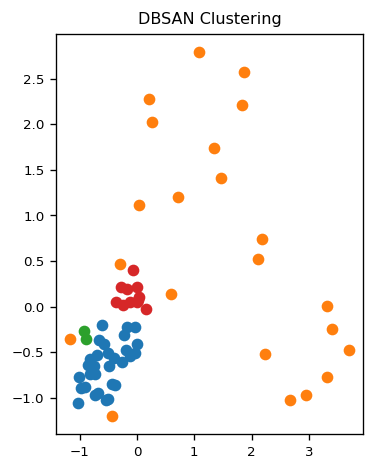

In [ ]:
import pdb
def functionDBscannew(z,distfunct,epsilon,minpts):
  z=z
  epsilon=epsilon
  minpts=minpts
  cluster=np.zeros([1,z.shape[0]])# vector of 1 row and n columns 
  c=0
  for i in range(z.shape[0]):#iterate over all the points 
      if cluster[0,i]!=0:#Means cluster is labeled 
         continue # skip all the the below steps 
      index=rangequery(z,distfunct,i,epsilon)# run the query to find distances between all the  points
      if len(index)<minpts:#length of Neigbhourhood less than threshold 
          cluster[0,i]=-1# represents noise 
          continue# skip below process as we have identified noise elements for given point 
      revised_set=index#set of neighbour hood sets 
      c=c+1  #Add cluster number
      cluster[0,i]=c
      for m in revised_set:#all indexes  in density reachable points
             if cluster[0,m]==-1:
                cluster[0,m]=c#new label as outer point
                continue
             if cluster[0,m]!=0:#cluster is not undefined then (or if cluster is defined then we skip and move to next set)
                continue
             cluster[0,m]=c# relabel again direct connected points
             Index_new=rangequery(z,distfunct,m,epsilon)
             if (len(Index_new))<minpts:
                  continue
             else:
               revised_set.extend(Index_new)
                  # break the loop and move on to new  point  in original for loop
     
  return cluster
#
p=functionDBscannew(data1,distfunct,epsilon=0.2,minpts=2)
Z=data1
p2=np.array(p)[0]
import matplotlib.pyplot as plt
plt.scatter(Z[p2==1,0],Z[p2==1,1])
plt.scatter(Z[p2==-1,0],Z[p2==-1,1])
plt.scatter(Z[p2==2,0],Z[p2==2,1])
plt.scatter(Z[p2==3,0],Z[p2==3,1])
plt.title('DBSAN Clustering')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from collections import defaultdict
import pandas as pd

epsilon=[0.2,0.3,0.4]
Minpoints=[2,3,4]


score1=normalized_mutual_info_score(labels_true=labels1,labels_pred=p2)
r=defaultdict(list)
container=np.zeros([data1.shape[0],len(epsilon),len(Minpoints)])
score_container=np.zeros([len(epsilon),len(Minpoints)])
score2_container=np.zeros([len(epsilon),len(Minpoints)])
data=[]
counter=0
for i in range(len(epsilon)):
  for k  in range(len(Minpoints)):
     p=functionDBscannew(data1,distfunct,epsilon[i],Minpoints[k])
     p2=np.array(p)[0]
     score1=normalized_mutual_info_score(labels_true=labels1,labels_pred=p2)
     score2=silhouette_score(data1, p2, metric='euclidean')
     score3=calinski_harabasz_score(data1,p2)
     score_container[i,k]=score1
     score2_container[i,k]=score2
     r[counter].append(score1)
     r[counter].append(Minpoints[k])
     r[counter].append(epsilon[i])
     r[counter].append(score2)
     r[counter].append(score3)
     counter=counter+1
score_container
p=np.where(score_container == np.max(score_container))
print(p[0],p[1])
#Hence the hyper parameters choosen are :
print("The optimum parameters choosen for epsilon based on Normalized Mutual Score is   ",epsilon[p[0][0]]," and value of Min points is ",Minpoints[p[1][0]])

df=pd.DataFrame(r.values())
df2=df.rename(columns={0:'NHIscore',1:'Min Points',2:'Epsilon',3:'Silhouttes Score',4:'CH Sc'})
print(df2)

[2] [1]
The optimum parameters choosen for epsilon based on Normalized Mutual Score is    0.4  and value of Min points is  3
   NHIscore  Min Points  Epsilon  Silhouttes Score       CH Sc
0  0.620469           2      0.2          0.278685   56.398911
1  0.617866           3      0.2          0.282963   57.485186
2  0.588435           4      0.2          0.208857   43.836197
3  0.796711           2      0.3          0.369168  121.574713
4  0.807066           3      0.3          0.454579  175.986968
5  0.810891           4      0.3          0.548633  222.537802
6  0.924552           2      0.4          0.571100  286.633739
7  0.925131           3      0.4          0.648442  351.590560
8  0.916846           4      0.4          0.648147  344.058036


In [ ]:
from collections import defaultdict
import pandas as pd

epsilon=[0.8,0.85,0.4]
Minpoints=[6,7,8]

def clusterevaluation(epsilon,Minpoints,data,labels):
  r=defaultdict(list)
  container=np.zeros([data.shape[0],len(epsilon),len(Minpoints)])
  score_container=np.zeros([len(epsilon),len(Minpoints)])
  score2_container=np.zeros([len(epsilon),len(Minpoints)])
  counter=0
  for i in range(len(epsilon)):
    for k  in range(len(Minpoints)):
      p=functionDBscannew(data,distfunct,epsilon[i],Minpoints[k])
      p2=np.array(p)[0]
      score1=normalized_mutual_info_score(labels_true=labels,labels_pred=p2)
      score2=silhouette_score(data, p2, metric='euclidean')
      score3=calinski_harabasz_score(data,p2)
      score_container[i,k]=score1
      score2_container[i,k]=score2
      r[counter].append(score1)
      r[counter].append(Minpoints[k])
      r[counter].append(epsilon[i])
      r[counter].append(score2)
      r[counter].append(score3)
      counter=counter+1
  score_container
  p=np.where(score_container == np.max(score_container))
  print(p[0],p[1])
  #Hence the hyper parameters choosen are :
  print("The optimum parameters choosen for epsilon based on Normalized Mutual Score is   ",epsilon[p[0][0]]," and value of Min points is ",Minpoints[p[1][0]])

  df=pd.DataFrame(r.values())
  df2=df.rename(columns={0:'NHIscore',1:'Min Points',2:'Epsilon',3:'Silhouttes Score',4:'CH Sc'})
  return df2 

In [ ]:
df2=clusterevaluation(epsilon,Minpoints,data2,labels2)
df2

[1] [0]
The optimum parameters choosen for epsilon based on Normalized Mutual Score is    0.85  and value of Min points is  6


,NHIscore,Min Points,Epsilon,Silhouttes Score,CH Sc
0,0.923089,6,0.80,0.523033,236.814941
1,0.898193,7,0.80,0.516998,240.163438
2,0.885215,8,0.80,0.504435,237.491429
3,0.932188,6,0.85,0.527310,238.750599
4,0.901211,7,0.85,0.519034,243.498141
5,0.895326,8,0.85,0.513022,238.734590
6,0.804103,6,0.40,0.329096,151.834199
7,0.826892,7,0.40,0.302779,165.472547
8,0.881770,8,0.40,0.334222,218.283285


In [ ]:
from collections import defaultdict
import pandas as pd

epsilon=[0.8,0.85,0.4]
Minpoints=[6,7,8]

def clusterevaluation(epsilon,Minpoints,data,labels):
  r=defaultdict(list)
  container=np.zeros([data.shape[0],len(epsilon),len(Minpoints)])
  score_container=np.zeros([len(epsilon),len(Minpoints)])
  score2_container=np.zeros([len(epsilon),len(Minpoints)])
  counter=0
  for i in range(len(epsilon)):
    for k  in range(len(Minpoints)):
      p=functionDBscannew(data,distfunct,epsilon[i],Minpoints[k])
      p2=np.array(p)[0]
      score1=normalized_mutual_info_score(labels_true=labels,labels_pred=p2)
      score_container[i,k]=score1
      score2_container[i,k]=score2
      r[counter].append(score1)
      r[counter].append(Minpoints[k])
      r[counter].append(epsilon[i])
      counter=counter+1
  score_container
  p=np.where(score_container == np.max(score_container))
  print(p[0],p[1])
  #Hence the hyper parameters choosen are :
  print("The optimum parameters choosen for epsilon is  ",epsilon[p[0][0]]," and value of Min points is ",Minpoints[p[1][0]])

  df=pd.DataFrame(r.values())
  df2=df.rename(columns={0:'NHIscore',1:'Min Points',2:'Epsilon',3:'Silhouttes Score',4:'CH Sc'})
  return df2 

In [ ]:
print(labels3)


epsilon=[0.2,0.3,0.4]
Minpoints=[5,6,7]
df3=clusterevaluation(epsilon,Minpoints,data3,labels3)
df3

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 1 1] [0 1 2]
The optimum parameters choosen for epsilon is   0.3  and value of Min points is  5


,NHIscore,Min Points,Epsilon
0,7.889333e-01,5,0.2
1,7.593815e-01,6,0.2
2,7.593815e-01,7,0.2
3,1.000000e+00,5,0.3
4,1.000000e+00,6,0.3
5,1.000000e+00,7,0.3
6,2.562741e-15,5,0.4
7,2.562741e-15,6,0.4
8,2.562741e-15,7,0.4


In [ ]:
# for first data set we find optimum values at:0.4 and 3

In [ ]:
p=functionDBscannew(data1,distfunct,0.4,3)
p2=np.array(p)[0]

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2. -1.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3. -1.  3.  3.  3.
  3.  3.  3. -1.  3. -1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.]


Text(0.5, 1.0, 'Actual Labels')

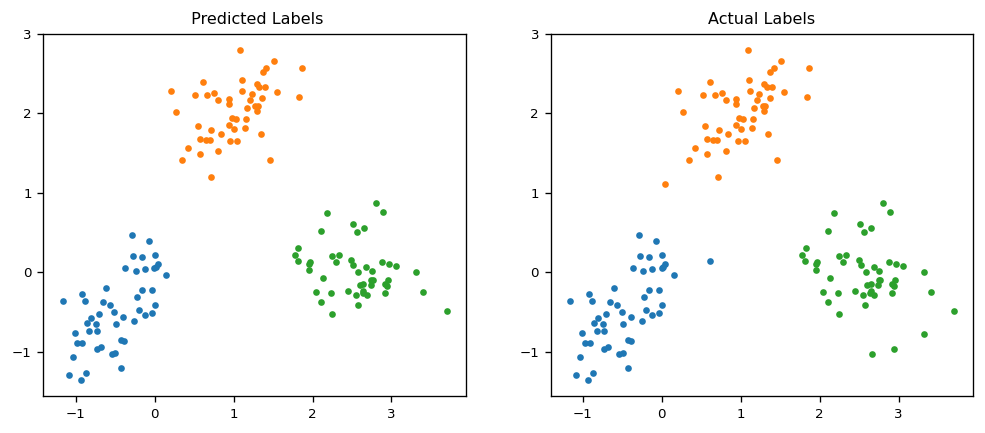

In [ ]:

def plot(data,distfunct,epsilon):
  p=functionDBscannew(data1,distfunct,0.4,3)
  p2=np.array(p)[0]
  fig, axs = plt.subplots(1,2)
  fig.set_size_inches(10,4)
  axs[0].plot(data1[p2==1,0],data1[p2==1,1],'.')
  axs[0].plot(data1[p2==2,0],data1[p2==2,1],'.')
  axs[0].plot(data1[p2==3,0],data1[p2==3,1],'.')
  axs[0].set_title(" Predicted Labels")

  def scatter_plot(ax, data, labels):
    K = len(np.unique(labels))#Length of Unique labels i.e K=3
    for k in range(K):
        idx_k = labels == (k + 1)#removing 0
        data_k = data[idx_k]#ids
        ax.plot(data_k[:,0], data_k[:,1], ".", label=k)

  scatter_plot(axs[1], data1, labels1)
  axs[1].set_title("Actual Labels")
  return 


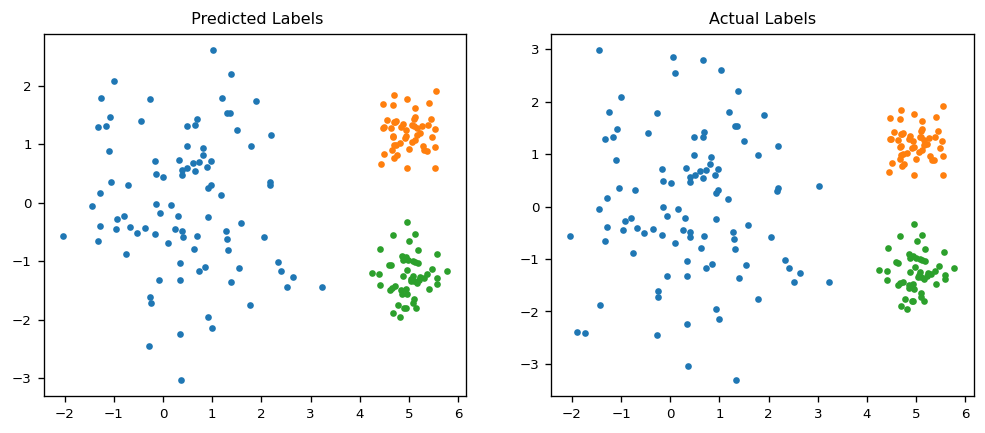

In [ ]:
def plot(data,distfunct,epsilon,minpts,labels):
  p=functionDBscannew(data,distfunct,epsilon,minpts)
  p2=np.array(p)[0]
  fig, axs = plt.subplots(1,2)
  fig.set_size_inches(10,4)
  axs[0].plot(data[p2==1,0],data[p2==1,1],'.')
  axs[0].plot(data[p2==2,0],data[p2==2,1],'.')
  axs[0].plot(data[p2==3,0],data[p2==3,1],'.')
  axs[0].set_title(" Predicted Labels")

  def scatter_plot(ax, data, labels):
    K = len(np.unique(labels))#Length of Unique labels i.e K=3
    for k in range(K):
        idx_k = labels == (k + 1)#removing 0
        data_k = data[idx_k]#ids
        ax.plot(data_k[:,0], data_k[:,1], ".", label=k)

  scatter_plot(axs[1], data, labels)
  axs[1].set_title("Actual Labels")
  return 
#Plotting as per best NHI score 
plot(data2,distfunct,0.85,6,labels2)

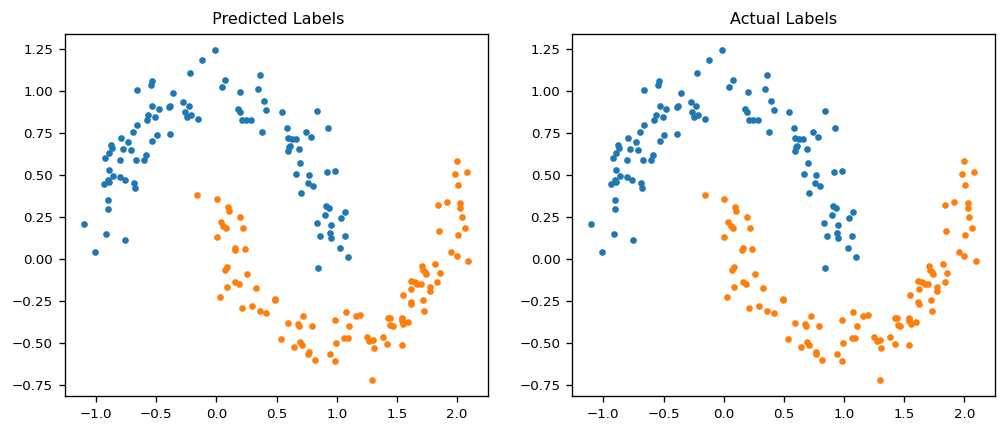

In [ ]:
plot(data3,distfunct,0.3,5,labels3)